# Amazon Fine Food Reviews Analysis
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

 Number of reviews: 568,454                                                                                                     
 Number of users: 256,059                                                                                                       
 Number of products: 74,258                                                                                                                                                                                                             
 Number of Attributes/Columns in data: 10
 
 Attributes:
1. IdRow Id
2. ProductIdUnique identifier for the product
3. UserIdUnqiue identifier for the user
4. ProfileNameProfile name of the user
5. HelpfulnessNumeratorNumber of users who found the review helpful
6. HelpfulnessDenominatorNumber of users who indicated whether they found the review helpful
7. ScoreRating between 1 and 5
8. TimeTimestamp for the review
9. SummaryBrief summary of the review
10. TextText of the review

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import pickle

In [5]:
# Loading 250 pts obtained after data preprocessing and sorting 

with open('C:/Users/U6069188/Python Projects/Pickle/FilteredData_250K','rb') as f:
    FilteredData = pickle.load(f)

In [6]:
FilteredData = FilteredData.head(5000)

FilteredData["Score"].value_counts()

positive    4113
negative     887
Name: Score, dtype: int64

In [7]:
#Score as positive/negative -> 0/1
def polarity(x):
    if x == "positive":
        return 1
    else:
        return -1

FilteredData["Score"] = FilteredData["Score"].map(polarity)

FilteredData["Score"].value_counts()

 1    4113
-1     887
Name: Score, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(FilteredData['CleanedText'].values, FilteredData['Score'].values, train_size=.7)

In [10]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(320,) (318,)
(638,) (318,)
(956,) (318,)
(1274,) (318,)
(1592,) (318,)
(1910,) (318,)
(2228,) (318,)
(2546,) (318,)
(2864,) (318,)
(3182,) (318,)


In [11]:
from sklearn.datasets import *
from sklearn.svm import SVC
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.linear_model import SGDClassifier
import pandas as pd
import seaborn as sns       

def RunSVC_GridCV(X_train, y_train):
    
    C = [10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01]
    gamma = [10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01]

    hyperparameters = dict(C=C, gamma = gamma)
    
    svd = TruncatedSVD()
    X_train = svd.fit_transform(X_train)
    tscv = TimeSeriesSplit(n_splits=10)
    print(X_train.shape)
    model_grid = GridSearchCV(SVC(),hyperparameters, cv=tscv,scoring='accuracy')
    model_grid.fit(X_train, y_train)
    
    print(model_grid.best_estimator_)
    
    optimalc_grid = list(model_grid.best_estimator_.get_params().items())[0]
    optimalgamma_grid = list(model_grid.best_estimator_.get_params().items())[6]
    print('optimal C value using GridSearchCV',optimalc_grid)
    print('optimal gamma value using GridSearchCV',optimalgamma_grid)
    
    pvt = pd.pivot_table(pd.DataFrame(model_grid.cv_results_),values='mean_test_score', index='param_C', columns='param_gamma')
    
    ax = sns.heatmap(pvt)
    
    return optimalc_grid,optimalgamma_grid
    

def RunSGD_GridCV(X_train, y_train):
    print('**********************************************L1 Regularizer******************************************************')
    alpha = [10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
    param_dist = {'penalty': ['l1'],
                  'alpha':alpha} 
    
    clf = SGDClassifier(class_weight='balanced',loss="hinge")

    model_grid = GridSearchCV(estimator = clf,param_grid= param_dist, cv=5)
    model_grid.fit(X_train, y_train)
        
    print('Best Estimator using Grid search :',model_grid.best_estimator_)
    
    optimalalphal1_grid = list(model_grid.best_estimator_.get_params().items())[0]

    print('optimal alpha value using GridSearchCV',optimalalphal1_grid[1])
    
    best_parameters = model_grid.best_estimator_.get_params()

    cv_scores = model_grid.cv_results_['mean_test_score']
    MSE = []
    for x in cv_scores:
        MSE.append(1-x)
        
    plt.plot(alpha, MSE)

    plt.xlabel('Alpha values')
    plt.ylabel('Misclassification Error')
    plt.show()
    
    print('**********************************************L2 Regularizer******************************************************')
    
    alpha = [10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
    param_dist = {'penalty': ['l2'],
                  'alpha':alpha} 
    
    clf = SGDClassifier(class_weight='balanced',loss="hinge")

    model_grid = GridSearchCV(estimator = clf,param_grid= param_dist, cv=5)
    model_grid.fit(X_train, y_train)
        
    print('Best Estimator using Grid search :',model_grid.best_estimator_)
    
    optimalalphal2_grid = list(model_grid.best_estimator_.get_params().items())[0]

    print('optimal alpha value using GridSearchCV',optimalalphal2_grid[1])
    
    best_parameters = model_grid.best_estimator_.get_params()
    
    cv_scores = model_grid.cv_results_['mean_test_score']
    MSE = []
    for x in cv_scores:
        MSE.append(1-x)
        
    plt.plot(alpha, MSE)

    plt.xlabel('Alpha values')
    plt.ylabel('Misclassification Error')
    plt.show()
    
    return optimalalphal1_grid,optimalalphal2_grid,model_grid

    
def Run_SVC(X_train, y_train,X_test,y_test,optimalc,optimalgamma):
    
    model = SVC(class_weight='balanced',C=optimalc,gamma = optimalgamma);
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    #Accuracy on train data
    train_acc = model.score(X_train, y_train)
    train_err = 1-train_acc
        
    #Accuracy on test data
    test_acc = accuracy_score(y_test, pred)*100
    test_err = 1- test_acc
        
    print('*'*120)
    print('Optimal C is' ,optimalc)
    print('Optimal gamma is' ,optimalgamma)
    print('Accuracy for LogisticReg algorithm with lambda  is ' ,np.round((accuracy_score(y_test, pred)*100),decimals = 2))
    print('F1 score for LogisticReg algorithm with lambda  is ' , np.round((f1_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Recall for LogisticReg agorithm with lambda is ' , np.round((recall_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Precision for LogisticReg algorithm with lambda is ' , np.round((precision_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print ('\n Classification report for LogisticReg algorithm with lambda is \n ' , classification_report(y_test,pred))
    
    cm= confusion_matrix(y_test, pred)
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return train_err,test_err

def Run_SGDClassifier(X_train, y_train,X_test,y_test,optimalalpha):
    
    model = SGDClassifier(class_weight='balanced',alpha=optimalalpha,penalty='l1');
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    #Accuracy on train data
    train_acc = model.score(X_train, y_train)
    train_err = 1-train_acc
        
    #Accuracy on test data
    test_acc = accuracy_score(y_test, pred)*100
    test_err = 1- test_acc
        
    print('*'*120)
    print('Optimal alpha is' ,optimalalpha)
    print('Accuracy for SGD Hinge algorithm with lambda  is ' ,np.round((accuracy_score(y_test, pred)*100),decimals = 2))
    print('F1 score for SGD Hinge algorithm with lambda  is ' , np.round((f1_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Recall for SGD Hinge agorithm with lambda is ' , np.round((recall_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Precision for SGD Hinge algorithm with lambda is ' , np.round((precision_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print ('\n Classification report for SGD Hinge algorithm with lambda is \n ' , classification_report(y_test,pred))
    
    cm= confusion_matrix(y_test, pred)
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return train_err,test_err

def FeatureImp(X_train,y_train,model,vectorizer):
    w = model.best_estimator_.coef_
    B = vectorizer.get_feature_names()
    
    data_df = {'features': B, 'weightvec': list(w)[0]}
    
    df = pd.DataFrame(data = data_df)
    data_nonzero = df[df['weightvec'] != 0]
    print('******************Positive Features*********************')
    print(data_nonzero.sort_values('weightvec',ascending = False).head(10))
    print('******************Negative Features*********************')
    print(data_nonzero.sort_values('weightvec',ascending = True).head(10))

# BOW

In [12]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn import preprocessing

bow = CountVectorizer(binary = True).fit(X_train)

In [13]:
X_train_bow = bow.transform(X_train)

In [14]:
X_test_bow = bow.transform(X_test)

In [15]:
#Normalize Train Data
X_train_bow = preprocessing.normalize(X_train_bow)
X_train_bow.shape

(3500, 8906)

In [16]:
#Normalize Test Data
X_test_bow = preprocessing.normalize(X_test_bow)
X_test_bow.shape

(1500, 8906)

(3500, 2)
SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
optimal C value using GridSearchCV ('C', 10000)
optimal gamma value using GridSearchCV ('gamma', 10)


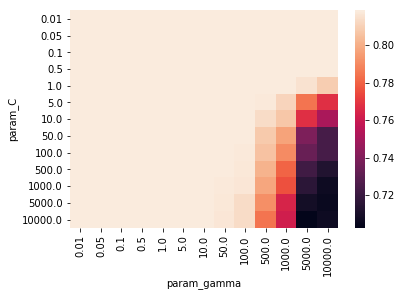

In [17]:
optimalc_grid_bow,optimalgamma_grid_bow = RunSVC_GridCV(X_train_bow, y_train)

**********************************************L1 Regularizer******************************************************
Best Estimator using Grid search : SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
optimal alpha value using GridSearchCV 0.0001


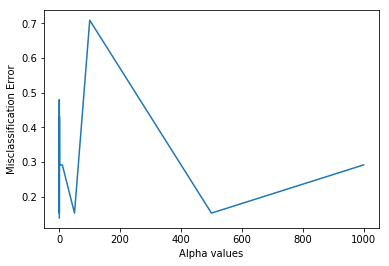

**********************************************L2 Regularizer******************************************************
Best Estimator using Grid search : SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
optimal alpha value using GridSearchCV 0.0001


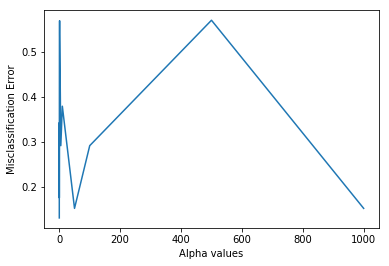

In [15]:
optimalalphal1_grid_bow,optimalalphal2_grid_bow,model = RunSGD_GridCV(X_train_bow, y_train)

************************************************************************************************************************
Optimal alpha is 0.0001
Accuracy for SGD Hinge algorithm with lambda  is  85.79
F1 score for SGD Hinge algorithm with lambda  is  77.84
Recall for SGD Hinge agorithm with lambda is  85.97
Precision for SGD Hinge algorithm with lambda is  74.43

 Classification report for SGD Hinge algorithm with lambda is 
                precision    recall  f1-score   support

          -1       0.52      0.86      0.65     11270
           1       0.97      0.86      0.91     63730

   micro avg       0.86      0.86      0.86     75000
   macro avg       0.74      0.86      0.78     75000
weighted avg       0.90      0.86      0.87     75000



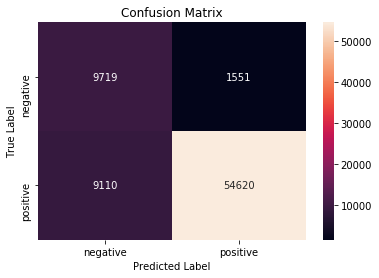

In [16]:
train_err_sgd_bow,test_err_sgd_bow = Run_SGDClassifier(X_train_bow, y_train,X_test_bow,y_test,optimalalphal1_grid_bow[1])

In [17]:
FeatureImp(X_train_bow,y_test,model,bow)

******************Positive Features*********************
      features  weightvec
11337   delici   3.923725
4042      best   3.858053
18668    great   3.856755
32311  perfect   3.568933
14794    excel   3.513709
25426     love   3.054339
1345      amaz   3.036146
2891    awesom   2.737467
29331     nice   2.597484
15442  favorit   2.447276
******************Negative Features*********************
         features  weightvec
12191  disappoint  -4.640466
48697       worst  -3.752224
45826    unfortun  -3.210496
2871           aw  -3.160985
43389     terribl  -3.159689
20638     horribl  -3.017903
36479      return  -2.951643
4505        bland  -2.823340
41075       stale  -2.610686
47687        weak  -2.406554


************************************************************************************************************************
Optimal C is 10000
Optimal gamma is 10
Accuracy for LogisticReg algorithm with lambda  is  82.87
F1 score for LogisticReg algorithm with lambda  is  46.81
Recall for LogisticReg agorithm with lambda is  50.77
Precision for LogisticReg algorithm with lambda is  91.41

 Classification report for LogisticReg algorithm with lambda is 
                precision    recall  f1-score   support

          -1       1.00      0.02      0.03       261
           1       0.83      1.00      0.91      1239

   micro avg       0.83      0.83      0.83      1500
   macro avg       0.91      0.51      0.47      1500
weighted avg       0.86      0.83      0.75      1500



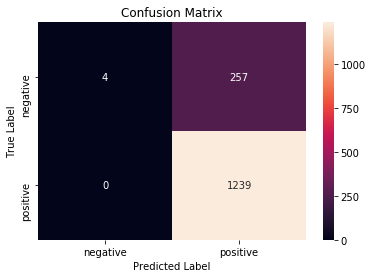

In [18]:
train_err_svc_bow,test_err_svc_bow = Run_SVC(X_train_bow, y_train,X_test_bow,y_test,optimalc_grid_bow[1],optimalgamma_grid_bow[1])

# Tf-Idf

In [19]:
tfidf = TfidfVectorizer(ngram_range=(1,2),min_df = 5).fit(X_train)

In [20]:
X_train_tfidf = tfidf.transform(X_train)

In [21]:
X_test_tfidf= tfidf.transform(X_test)

In [22]:
#Normalize Train Data
X_train_tfidf = preprocessing.normalize(X_train_tfidf)
X_train_tfidf.shape

(3500, 5258)

In [23]:
#Normalize Test Data
X_test_tfidf = preprocessing.normalize(X_test_tfidf)
X_test_tfidf.shape

(1500, 5258)

(3500, 2)
SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
optimal C value using GridSearchCV ('C', 10000)
optimal gamma value using GridSearchCV ('gamma', 5)


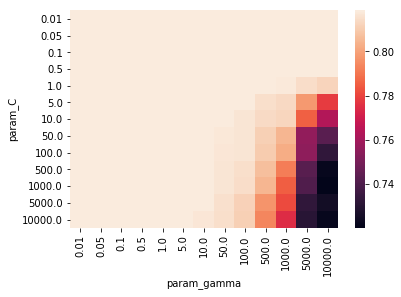

In [24]:
optimalc_grid_tfidf,optimalgamma_grid_tfidf = RunSVC_GridCV(X_train_tfidf, y_train)

**********************************************L1 Regularizer******************************************************
Best Estimator using Grid search : SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
optimal alpha value using GridSearchCV 0.0001


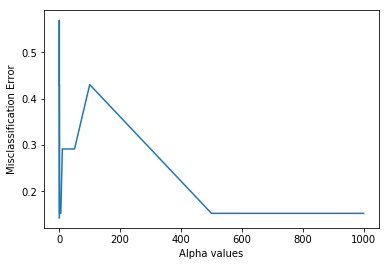

**********************************************L2 Regularizer******************************************************
Best Estimator using Grid search : SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
optimal alpha value using GridSearchCV 0.0001


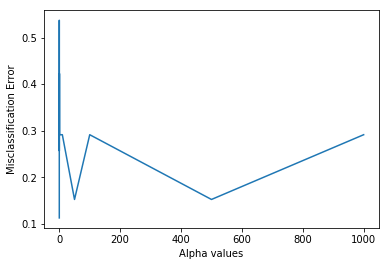

In [23]:
optimalalphal1_grid_tfidf,optimalalphal2_grid_tfidf,model = RunSGD_GridCV(X_train_tfidf, y_train)

************************************************************************************************************************
Optimal alpha is 0.0001
Accuracy for SGD Hinge algorithm with lambda  is  85.51
F1 score for SGD Hinge algorithm with lambda  is  77.52
Recall for SGD Hinge agorithm with lambda is  85.79
Precision for SGD Hinge algorithm with lambda is  74.14

 Classification report for SGD Hinge algorithm with lambda is 
                precision    recall  f1-score   support

          -1       0.51      0.86      0.64     11270
           1       0.97      0.85      0.91     63730

   micro avg       0.86      0.86      0.86     75000
   macro avg       0.74      0.86      0.78     75000
weighted avg       0.90      0.86      0.87     75000



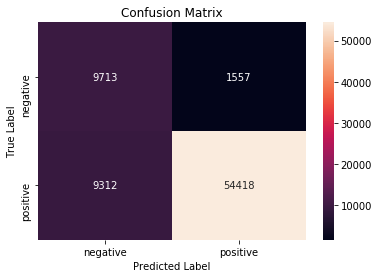

In [24]:
train_err_sgd_tfidf,test_err_sgd_tfidf = Run_SGDClassifier(X_train_tfidf, y_train,X_test_tfidf,y_test,optimalalphal1_grid_tfidf[1])

In [25]:
FeatureImp(X_train_bow,y_test,model,tfidf)

******************Positive Features*********************
              features  weightvec
83820            great   7.603122
109780            love   6.343779
16227             best   6.188120
48919           delici   5.332394
137736         perfect   4.625578
63432            excel   4.182982
81347             good   4.104366
124855            nice   3.709162
67151          favorit   3.393695
89997   high recommend   3.199578
******************Negative Features*********************
          features  weightvec
52183   disappoint  -6.224843
210928       worst  -3.786692
187796     terribl  -3.555084
198809    unfortun  -3.286478
155783      return  -3.193449
11792          bad  -3.175710
91477      horribl  -3.076903
190912     thought  -3.014136
10587           aw  -3.004557
115282        mayb  -2.774786


************************************************************************************************************************
Optimal C is 10000
Optimal gamma is 5
Accuracy for LogisticReg algorithm with lambda  is  82.87
F1 score for LogisticReg algorithm with lambda  is  46.81
Recall for LogisticReg agorithm with lambda is  50.77
Precision for LogisticReg algorithm with lambda is  91.41

 Classification report for LogisticReg algorithm with lambda is 
                precision    recall  f1-score   support

          -1       1.00      0.02      0.03       261
           1       0.83      1.00      0.91      1239

   micro avg       0.83      0.83      0.83      1500
   macro avg       0.91      0.51      0.47      1500
weighted avg       0.86      0.83      0.75      1500



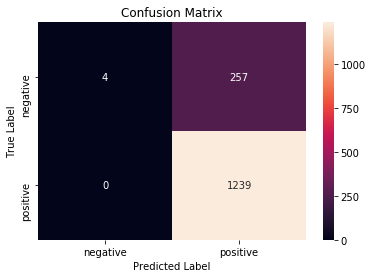

In [25]:
train_err_svc_tfidf,test_err_svc_tfidf = Run_SVC(X_train_tfidf, y_train,X_test_tfidf,y_test,optimalc_grid_tfidf[1],optimalgamma_grid_tfidf[1])

# AvgW2V

In [26]:
with open('C:/Users/U6069188/Python Projects/Pickle/AvgW2V','rb') as f:
    AvgW2V = pickle.load(f)

In [27]:
X = np.array(AvgW2V)
X = X[0:5000,]

In [28]:
y = FilteredData['Score'].values

In [29]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=.7)

In [30]:
#from sklearn.preprocessing import StandardScaler
#X_train = StandardScaler(with_mean = False).fit_transform(X_train)
#X_train.shape

In [31]:
#X_test = StandardScaler(with_mean = False).fit_transform(X_test)
#X_test.shape

(3500, 2)
SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
optimal C value using GridSearchCV ('C', 10000)
optimal gamma value using GridSearchCV ('gamma', 0.01)


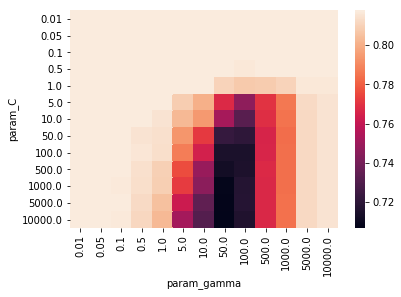

In [32]:
optimalc_grid_AvgW2V,optimalgamma_grid_AvgW2V = RunSVC_GridCV(X_train, y_train)

**********************************************L1 Regularizer******************************************************
Best Estimator using Grid search : SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
optimal alpha value using GridSearchCV 0.001


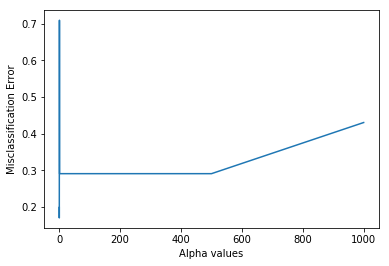

**********************************************L2 Regularizer******************************************************
Best Estimator using Grid search : SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
optimal alpha value using GridSearchCV 0.001


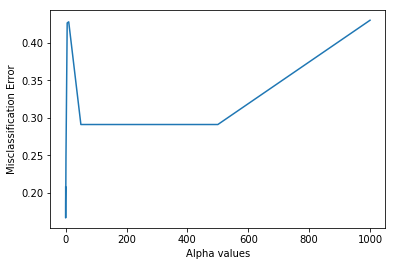

In [32]:
optimalalphal1_grid_AvgW2V,optimalalphal2_grid_AvgW2V,model_AvgW2V = RunSGD_GridCV(X_train, y_train)

************************************************************************************************************************
Optimal alpha is 0.001
Accuracy for SGD Hinge algorithm with lambda  is  82.06
F1 score for SGD Hinge algorithm with lambda  is  73.93
Recall for SGD Hinge agorithm with lambda is  83.86
Precision for SGD Hinge algorithm with lambda is  71.15

 Classification report for SGD Hinge algorithm with lambda is 
                precision    recall  f1-score   support

          -1       0.45      0.86      0.59     11369
           1       0.97      0.81      0.88     63631

   micro avg       0.82      0.82      0.82     75000
   macro avg       0.71      0.84      0.74     75000
weighted avg       0.89      0.82      0.84     75000



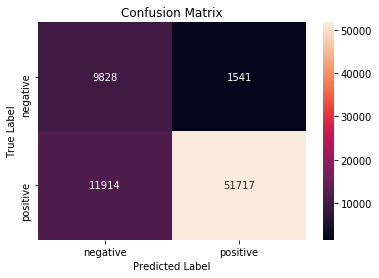

In [33]:
train_err_sgd_AvgW2V,test_err_sgd_AvgW2V = Run_SGDClassifier(X_train, y_train,X_test,y_test,optimalalphal1_grid_AvgW2V[1])

************************************************************************************************************************
Optimal C is 10000
Optimal gamma is 0.01
Accuracy for LogisticReg algorithm with lambda  is  83.53
F1 score for LogisticReg algorithm with lambda  is  70.69
Recall for LogisticReg agorithm with lambda is  70.79
Precision for LogisticReg algorithm with lambda is  70.59

 Classification report for LogisticReg algorithm with lambda is 
                precision    recall  f1-score   support

          -1       0.51      0.52      0.51       252
           1       0.90      0.90      0.90      1248

   micro avg       0.84      0.84      0.84      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.84      0.84      0.84      1500



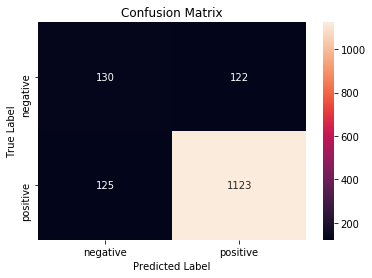

In [33]:
train_err_svc_AvgW2V,test_err_svc_AvgW2V = Run_SVC(X_train, y_train,X_test,y_test,optimalc_grid_AvgW2V[1],optimalgamma_grid_AvgW2V[1])

# TfIdf W2V

In [34]:
with open('C:/Users/U6069188/Python Projects/Pickle/tfidf_sent_vectors','rb') as f:
    tfidf_sent_vectors = pickle.load(f)

In [35]:
X = np.array(tfidf_sent_vectors)
X = X[0:5000,]
X.shape

(5000, 50)

In [36]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=.7)

In [37]:
#X_train = StandardScaler(with_mean = False).fit_transform(X_train)
#X_train.shape

In [38]:
#X_test = StandardScaler(with_mean = False).fit_transform(X_test)
#X_test.shape

(3500, 2)
SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1000, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
optimal C value using GridSearchCV ('C', 0.5)
optimal gamma value using GridSearchCV ('gamma', 1000)


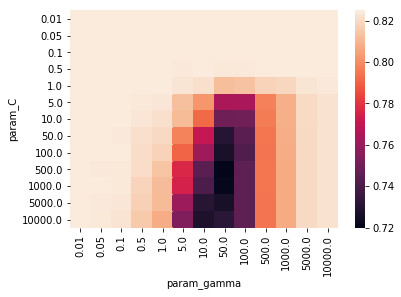

In [39]:
optimalc_grid_tfidfW2V,optimalgamma_grid_tfidfW2V = RunSVC_GridCV(X_train, y_train)

**********************************************L1 Regularizer******************************************************
Best Estimator using Grid search : SGDClassifier(alpha=0.005, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
optimal alpha value using GridSearchCV 0.005


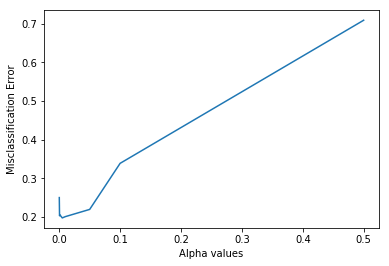

**********************************************L2 Regularizer******************************************************
Best Estimator using Grid search : SGDClassifier(alpha=0.005, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
optimal alpha value using GridSearchCV 0.005


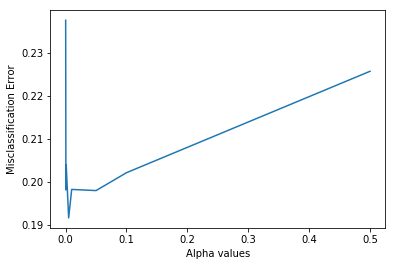

In [44]:
optimalalphal1_grid_tfidfW2V,optimalalphal2_grid_tfidfW2V,Model_tfidfW2V = RunSGD_GridCV(X_train, y_train)

************************************************************************************************************************
Optimal alpha is 0.005
Accuracy for SGD Hinge algorithm with lambda  is  79.52
F1 score for SGD Hinge algorithm with lambda  is  70.81
Recall for SGD Hinge agorithm with lambda is  80.68
Precision for SGD Hinge algorithm with lambda is  68.66

 Classification report for SGD Hinge algorithm with lambda is 
                precision    recall  f1-score   support

          -1       0.41      0.82      0.55     11340
           1       0.96      0.79      0.87     63660

   micro avg       0.80      0.80      0.80     75000
   macro avg       0.69      0.81      0.71     75000
weighted avg       0.88      0.80      0.82     75000



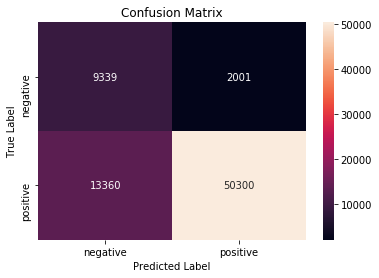

In [45]:
train_err_sgd_tfidfW2V,test_err_sgd_tfidfW2V = Run_SGDClassifier(X_train, y_train,X_test,y_test,optimalalphal1_grid_tfidfW2V[1])

************************************************************************************************************************
Optimal C is 10000
Optimal gamma is 1000
Accuracy for LogisticReg algorithm with lambda  is  80.93
F1 score for LogisticReg algorithm with lambda  is  44.73
Recall for LogisticReg agorithm with lambda is  50.0
Precision for LogisticReg algorithm with lambda is  40.47

 Classification report for LogisticReg algorithm with lambda is 
                precision    recall  f1-score   support

          -1       0.00      0.00      0.00       286
           1       0.81      1.00      0.89      1214

   micro avg       0.81      0.81      0.81      1500
   macro avg       0.40      0.50      0.45      1500
weighted avg       0.66      0.81      0.72      1500



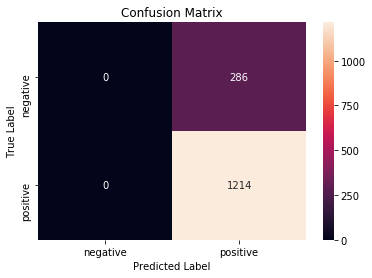

In [40]:
train_err_svc_tfidfW2V,test_err_svc_tfidfW2V = Run_SVC(X_train, y_train,X_test,y_test,optimalc_grid_AvgW2V[1],optimalgamma_grid_tfidfW2V[1])

In [41]:
from prettytable import PrettyTable
    
x = PrettyTable()

In [42]:
x.field_names = ["Model", "Regularizer" , "Optimal alpha Value", "Train Error", "Test Error"]

In [45]:
x.add_row(["SGDClassifier For Bow","L1",optimalalphal1_grid_bow, train_err_sgd_bow*100,101+test_err_bow_grid])
x.add_row(["SGDClassifier For TfIdf","L1",optimalalphal1_grid_tfidf, train_err_grid_tfidf*100,101+test_err_grid_tfidf])
x.add_row(["SGDClassifier For AvgW2V","L1",optimalalphal1_grid_AvgW2V,train_err_grid_avgw2v*100,101+test_err_grid_avgw2v])
x.add_row(["SGDClassifier For tfidfW2V","L1",optimalalphal1_grid_tfidfW2V, train_err_grid_tfidfw2v*100,101+test_err_grid_tfidfw2v])

In [46]:
print(x)

+----------------------------+-------------+---------------------+-------------+--------------------+
|           Model            | Regularizer | Optimal alpha Value | Train Error |     Test Error     |
+----------------------------+-------------+---------------------+-------------+--------------------+
|   SGDClassifier For Bow    |      L1     |        0.0001       |    11.18    | 14.209999999999994 |
|  SGDClassifier For TfIdf   |      L1     |        0.0001       |     9.86    | 14.489999999999995 |
|  SGDClassifier For AvgW2V  |      L1     |        0.001        |    15.72    | 17.939999999999998 |
| SGDClassifier For tfidfW2V |      L1     |        0.005        |     20.5    | 20.480000000000004 |
+----------------------------+-------------+---------------------+-------------+--------------------+


Observations:
1. Tf-idf Featurization(alpha = 0.0001) gave the best results with accuracy of 85.79%.
2. Also tfidfW2V model is only giving postive results because of the imbalanced data(considering only 5k data points). 